# Feature Importance with LGBMRegressor with K-folds
It can be a good idea to reduce the number of features to only the most useful ones, and discard the rest.

This can lead to simpler models that generalize better. 

This notebook display the geature iumportance with a LGBMRegressor model.

## References
* [Notebook](https://www.kaggle.com/code/sanjaylalwani/tps-jun22-data-impute-lb-0-9) form [@sanjaylalwani](https://www.kaggle.com/sanjaylalwani) 

In [ ]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

plt.rcParams['axes.facecolor'] = '#0057b8' # blue

from sklearn.metrics import mean_squared_error


It is easy to measure the relative importance of each feature. 

In [ ]:
data_df = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv')

In [ ]:
miss_col = data_df.columns[data_df.isnull().any()]

Cross-validation means splitting the training set into K-folds (in this case, three). It randomly splits the training set into 3 distinct subsets called folds, then it trains and evaluates the model 3 times, picking a different fold.

We split the data such that the proportions between classes are the same in each fold as they
are in the whole dataset.

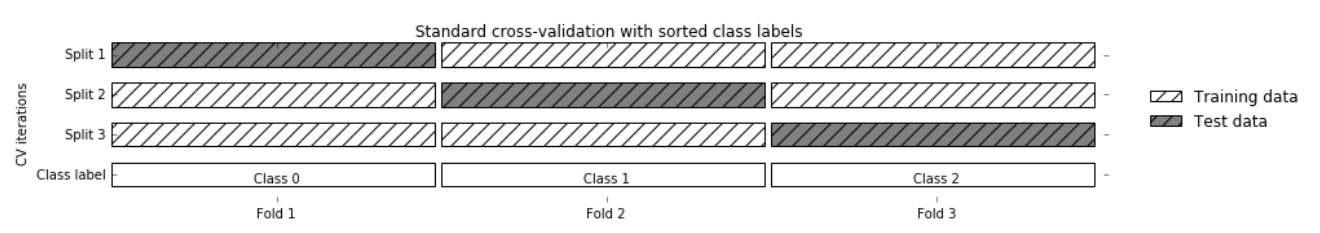

Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is

In [ ]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=3)

The result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.

Typical performance measure for regression problems is the Root Mean Square Error (RMSE). RMSE is the cost function measured on the set of examples (letter y in formula) `y_test_fold` using your hypothesis letter h in formula `y_pred`.

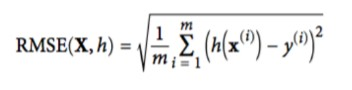

To regression model’s RMSE is prefered. Need to find the value a model that minimizes the RMSE.



In [ ]:
# https://www.kaggle.com/code/sanjaylalwani/tps-jun22-data-impute-lb-0-9?scriptVersionId=97733079&cellId=21
op_df = pd.DataFrame(columns=['row-col','value'])
all_rmse =[]

for col in miss_col:
    col_list=[x for x in miss_col if (col[:3] in x)]
    train = data_df.loc[(data_df[col].notnull())][col_list + ['row_id']]
    test = data_df.loc[(data_df[col].isnull())][col_list + ['row_id']]

    train0 = train.sample(frac=0.2)


    # select input variable
    X = train0.drop(["row_id",col], axis=1)
    # select output variable
    y = train0[col]

    #print(f"To col: {col} . Shape X: {X.shape} , y: {y.shape}")

    row_id = test["row_id"].astype(str)
    X_test = test.drop(["row_id",col], axis=1).copy()

    # define model
    model = LGBMRegressor(metric='rmse',n_estimators = 2000,learning_rate=0.1,max_depth=10)
    
    t_rmse = 0
    for train_index, test_index in kfolds.split(X, y):
        X_train_folds = X.iloc[train_index]
        y_train_folds = y.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_test_fold = y.iloc[test_index]

        # Fit a model
        model.fit(X_train_folds, y_train_folds)
        y_pred = model.predict(X_test_fold)
        rmse = mean_squared_error(y_test_fold, y_pred)
        t_rmse = t_rmse + rmse
    
    m_rmse = t_rmse/kfolds.n_splits      
    print(f"To Feature: {col} , Mean RMSE: {m_rmse}")
    all_rmse.append(m_rmse)
    ser = pd.Series( model.feature_importances_, index = model.feature_name_)
    ser = ser.sort_values(ascending=False)

    if col[:3] == 'F_3':
        plt.figure(figsize=(20, 4))
    else:
        plt.figure(figsize=(12, 4))
    plt.bar(ser.index, ser, color='#ffd700')
    plt.ylabel('Feature Importance')
    plt.xlabel('Features')
    plt.xticks(range(len(col_list)))
    #plt.xticks(ticks=ser.index, labels='MTWTFSS')
    plt.title(f"{col} , with Mean RMSE: {m_rmse}")
    plt.show()


# Plot Mean RMSE

Notice best estimation are low values.

In [ ]:
ser = pd.Series(all_rmse, index = miss_col.to_list())
ser = ser.sort_values(ascending=False)
ser.to_csv('all_rmse.csv')
plt.figure(figsize=(25, 8))
plt.bar(ser.index, ser, color='#ffd700')
plt.ylabel('Mean RMSE')
plt.xlabel('Features')
plt.xticks(range(len(miss_col)), rotation=90, fontsize=14)
plt.title("Mean RMSE vs Null Feature against")
plt.show()